# EPSF analysis of a galcen image with realistic ACE

We analyze a galcen image created by Jasmine-imagesim, considering realistic ACE (Attitude Control Error). The program used for this calculation is galcenimg.py in this directory. The input files are json files, also stored in this directory. For detailed settings, please check the json files. The output file is img_ver1_2_B.fits in this directory. We will analyze this file.

# Import modules
At first, we import some modules required in the following analysis.

In [1]:
import copy, warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.modeling import models, fitting
from astropy.nddata import NDData
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.background import MMMBackground
from photutils.detection import find_peaks
from photutils.psf import EPSFBuilder, extract_stars

# Analysis
We define a function used for the ePSF analysis. This function is almost the same as the previous ones, and I would like to ask you to see the code for details. However, I would like to provide some explanations here, mainly focusing on the differences from the previous codes.

The maximum number of iterations is set to 3 for the default setting, and we will not check the convergence of the fitting. Background subtraction is performed in the first step, while it was previously done in the later step. The threshold for peak detection is set to 100 sigma, where the sigma is determined by sigma-clipping analysis of the whole image. 
 
The ePSF analysis works for this image that contains many objects with various brightness and distances to neighbors, but many misidentifications are actually observed (Of course, the algorithm is still poor!). We found that such bad data cannot be removed by simple sigma-clipping analysis or median calculation. Additionally, a systematic deviation from the ideal positions given by the input catalog exists due to the ACE. Therefore, we iteratively create histograms and find the mode value of the deviations to estimate the systematic offset. We extract reliable data by confining the deviation in each x and y direction to be less than 0.1 px from the systematic offset.

In [20]:
def func(filename, sp_filename, n_maxiter=3, norm_radius=5.5, recentering_boxsize=5):
    '''
    filename: Name of the input FITS file.a
    sp_filename: Name of the input star-plate file.
    mag: Object magnitude.
    n_maxiter: Maximum number of iteration in ePSF analysis.
    norm_radius: Number of undersampled pixels 
                 which determines the radius for flux normalization of ePSF.
    recentering_boxsize: Number of undersampled pixels
                 which determines the box size for ePSF recentering calculation.
    '''
    
    mask_size = 25   # Edge mask size.
    ext_size  = 9    # Size of extraction window.
    n_oversample = 4 # Number of oversampling for ePSF.
#    n_maxiter    = 3 # Max. number of iteration for making ePSF.
#    mag = 12.0       # Object magnitude.
    threshold_level = 100.
#    print("Analyzing {}...".format(filename))
    max_dist_pix = 0.5

    # Loading image.
    hdu = pf.open(filename)[0]
    data = hdu.data.astype(np.float32)
#    norm = simple_norm(data, 'sqrt', percent=99.)
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.colorbar()
#    plt.show()
    
    # Subtracting background.
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
    image = copy.deepcopy(data)
    data -= mean_val
#    norm = simple_norm(data, 'sqrt', percent=99.)
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.colorbar()
#    plt.show()
    
    # Finding peaks.
    peaks_tbl = find_peaks(data, threshold=threshold_level*std_val)
    peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#    print(peaks_tbl)
    
    # Removing detections near edge.
    hsize = (mask_size - 1) / 2
    x = peaks_tbl['x_peak'] 
    y = peaks_tbl['y_peak'] 
    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
    print('Number of detected peaks: {}\n'.format(np.size(stars_tbl)))
    
    # Extracting stellar images.
    nddata = NDData(data=data)
#    print(nddata.data.shape)
    stars = extract_stars(nddata, stars_tbl, size=ext_size)
    nrows = 10
    ncols = 10
    print('Example of the extracted stellar images:')
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
    ax = ax.ravel()
    for i in range(nrows*ncols):
        norm = simple_norm(stars[i], 'log', percent=99.)
        ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
    plt.show()
    
    # Making ePSF.
    epsf_builder = EPSFBuilder(oversampling=n_oversample,
                               maxiters=n_maxiter, progress_bar=False,
                               norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                               center_accuracy=0.001)
    epsf, fitted_stars = epsf_builder(stars)
    print('Number of fitted stars: {}\n'.format(len(fitted_stars)))
    print('Derived ePSF image:')
    norm = simple_norm(epsf.data, 'log', percent=99.)
    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
    plt.xlabel('X (oversampled pix)')
    plt.ylabel('Y (oversampled pix)')
    plt.colorbar()
    plt.show()
    
    # Loading stellar-plate data.
    original = np.loadtxt(sp_filename,skiprows=1,delimiter=",")
    
    # Cross-checking the data.
    xc_array = []
    for o in original:
        cen_input = np.array([o[2]-1., o[3]-1.]) # 1-origin -> 0-origin
        diff = fitted_stars.center_flat - cen_input
        dist = np.sqrt(diff[:,0]**2.+diff[:,1]**2.)
        ind  = np.argmin(dist)
        xc_array.append([cen_input[0], cen_input[1],
                         fitted_stars.center_flat[ind][0],
                         fitted_stars.center_flat[ind][1]])
    xc_array = np.array(xc_array)
#    print(xc_array.shape)

    # Calculate offset
    def calc_offset(xc_array, offset_array, max_dev, nbin=200):
        dx = xc_array[:,2]-xc_array[:,0]-offset_array[0]
        dy = xc_array[:,3]-xc_array[:,1]-offset_array[1]
        hdx_n, hdx_b, hdx_p = plt.hist(dx, bins=nbin, range=[-max_dev, max_dev])
        plt.xlabel('dX-offset (px)')
        plt.ylabel('N of objects')
        plt.show()
        hdy_n, hdy_b, hdy_p = plt.hist(dy, bins=nbin, range=[-max_dev, max_dev])
        plt.xlabel('dY-offset (px)')
        plt.ylabel('N of objects')
        plt.show()
    
        x_offset = hdx_b[np.argmax(hdx_n)]
        y_offset = hdy_b[np.argmax(hdy_n)]
    
        print('Estimated residual offset dX: {} px'.format(x_offset))
        print('Estimated residual offset dY: {} px'.format(y_offset))
        print('\n')
        
        return np.array([offset_array[0]+x_offset, offset_array[1]+y_offset])
    
    print('Evaluating offset...')
    offset = calc_offset(xc_array, np.array([0, 0]), 10)
    print('Evaluating offset...')
    offset = calc_offset(xc_array, offset, 1)
    print('Evaluating offset...')
    offset = calc_offset(xc_array, offset, 0.1, nbin=20)
    
    print('Estimated offset dX: {} px'.format(offset[0]))
    print('Estimated offset dY: {} px'.format(offset[1]))
    print('\n')

    # Making dx/dy data.
    dx = xc_array[:,2] - xc_array[:,0] - offset[0]
    dy = xc_array[:,3] - xc_array[:,1] - offset[1]
    print('Deviation plot (all):')
    plt.scatter(dx, dy, marker='x')
    plt.xlabel('$\Delta$x-offset (px)')
    plt.ylabel('$\Delta$y-offset (px)')
    plt.xlim([-0.1,0.1])
    plt.ylim([-0.1,0.1])
    plt.show()
    
    # Making pix-phase error data.
    print('Deviation against pixel phase (all):')
    plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dx, marker='x', label='X')
    plt.scatter(xc_array[:,1]-(xc_array[:,1]+0.5).astype('int'), dy, marker='x', label='Y')
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.1,0.1])
    plt.xlabel('Pixel phase')
    plt.ylabel('Deviation-offset (px)')
    plt.legend()
    plt.show()
    
    # Vector plot.
    print('Deviation vector plot (reliable objects only; x2500):')
    pos = np.where((dx*dx<0.1**2.)&(dy*dy<0.1**2.))
    plt.axes().set_aspect('equal')
    plt.quiver(xc_array[pos,2], xc_array[pos,3], dx[pos], dy[pos],
               angles='xy', scale_units='xy', scale=0.0004)
    plt.xlabel('X (px)')
    plt.ylabel('Y (px)')
    plt.xlim([0, 1920])
    plt.ylim([0, 1920])
    plt.show()
    
    print('Number of reliable objects: {}'.format(np.size(pos)))
    print('\n')
    
    # Calculating stddev.
    print("STDDEV dX: {} px".format(np.std(dx[pos])))
    print("STDDEV dY: {} px".format(np.std(dy[pos])))

Then, execute the function.

Number of detected peaks: 334

Example of the extracted stellar images:


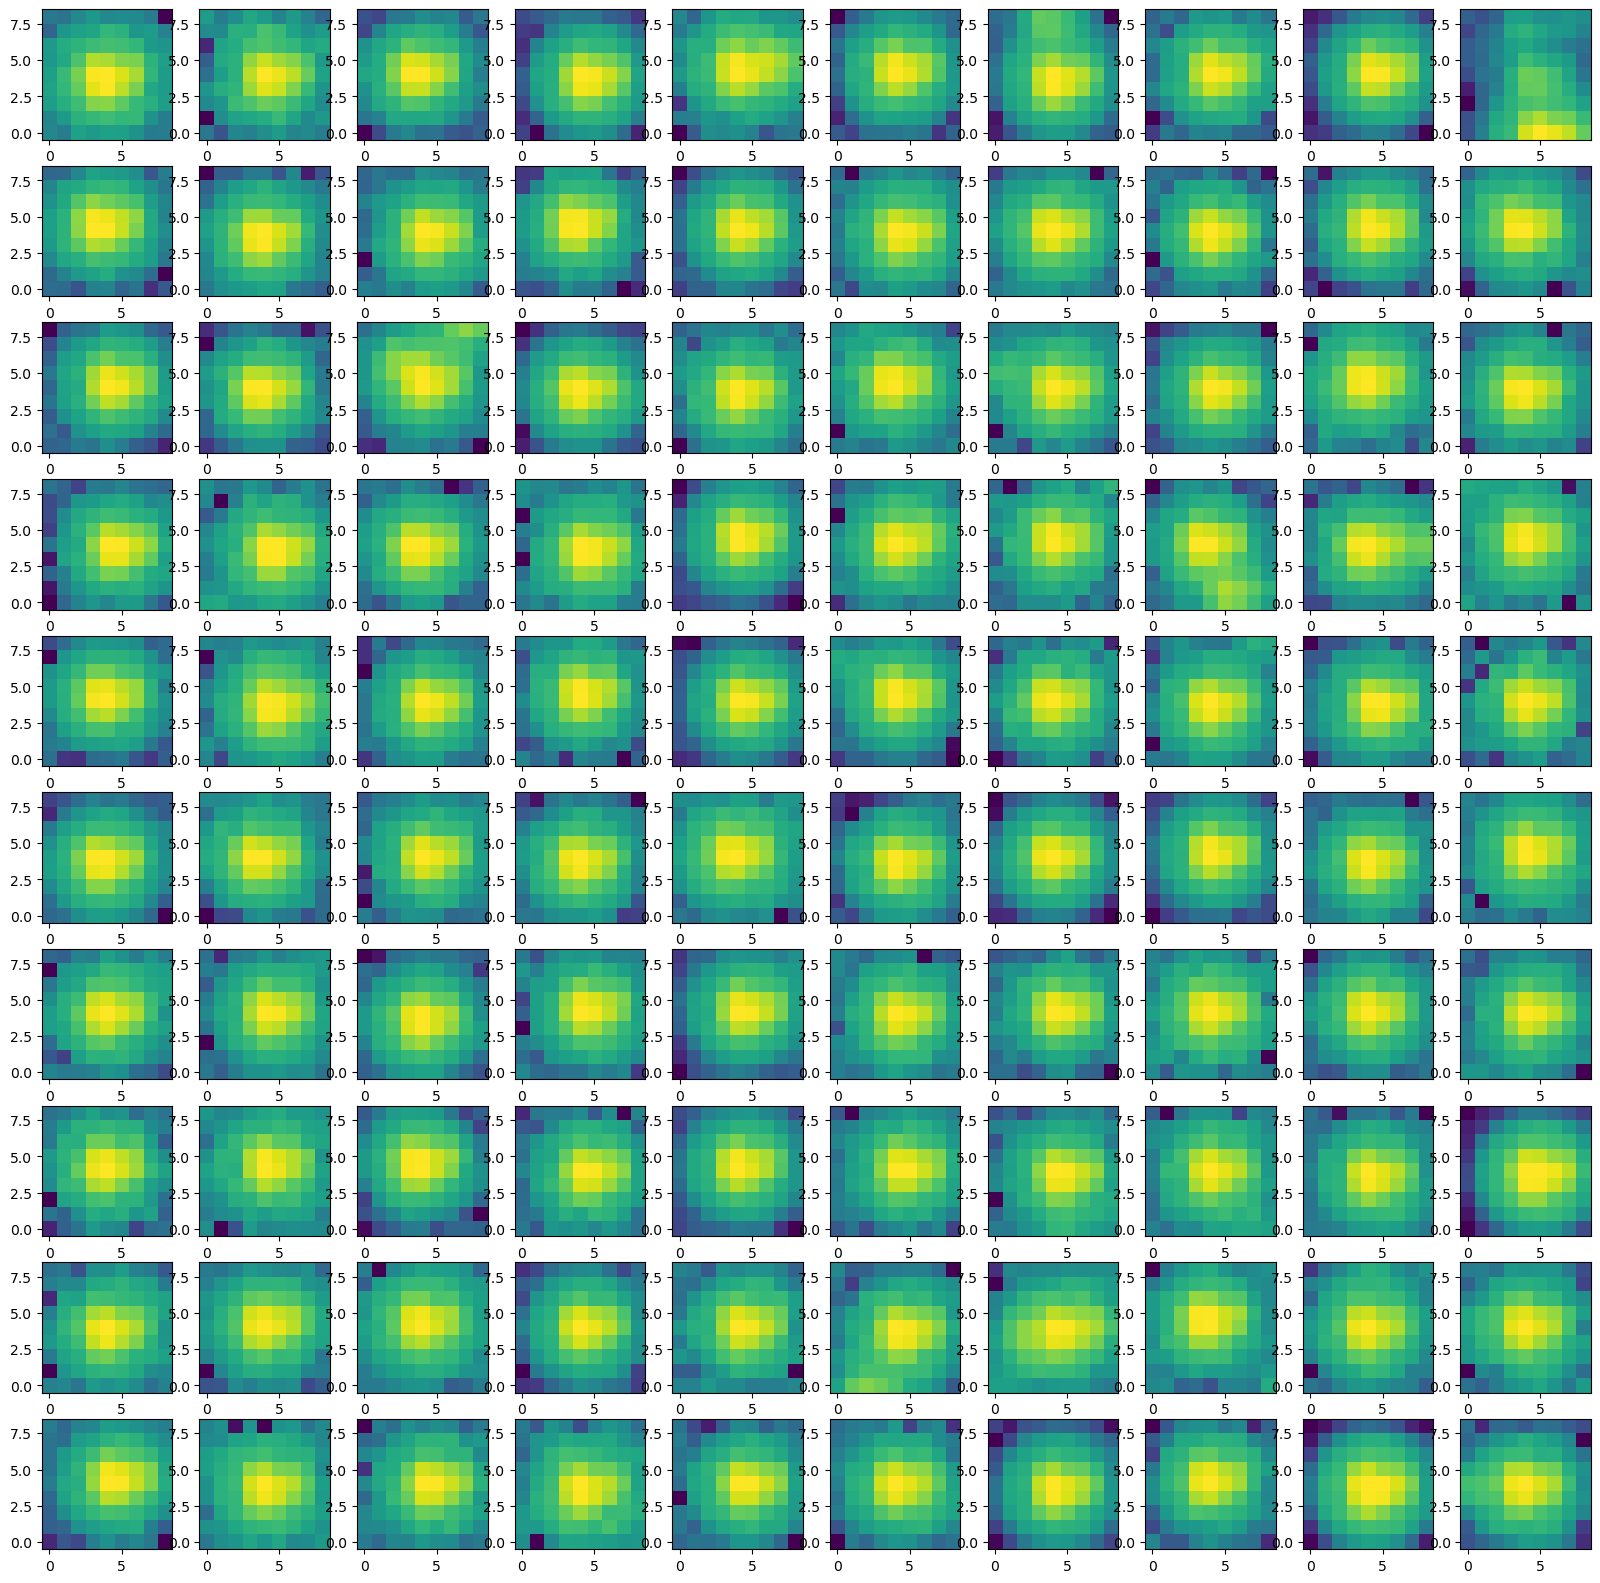

Number of fitted stars: 334

Derived ePSF image:


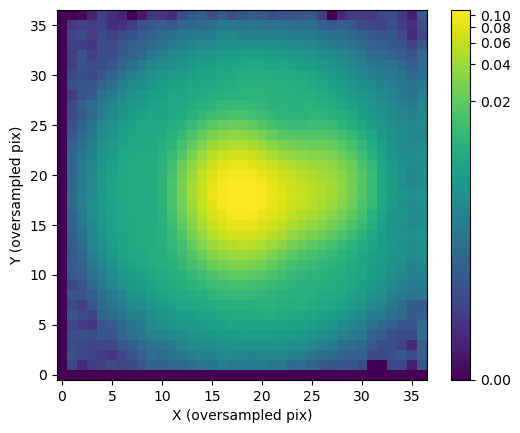

Evaluating offset...


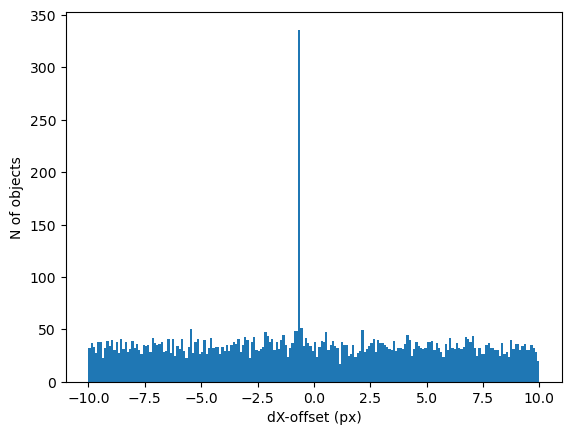

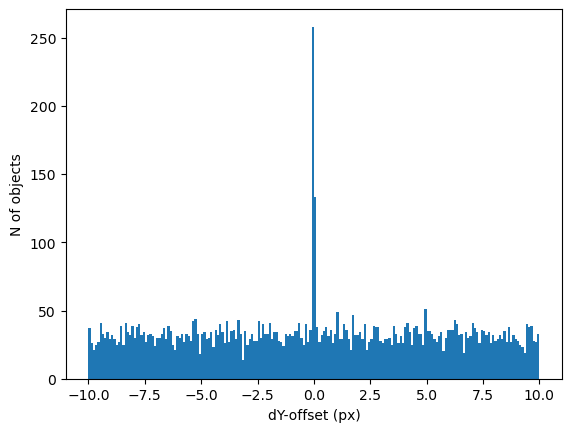

Estimated residual offset dX: -0.6999999999999993 px
Estimated residual offset dY: -0.09999999999999964 px


Evaluating offset...


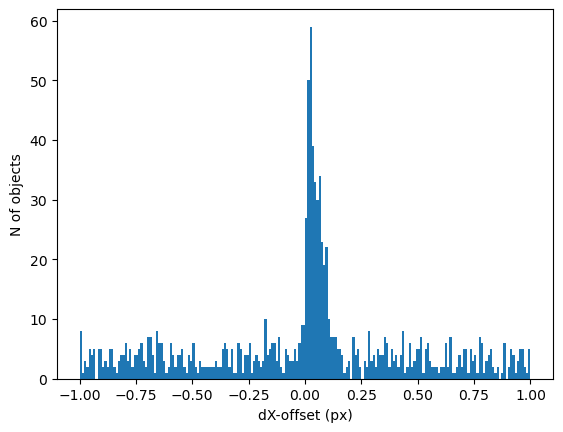

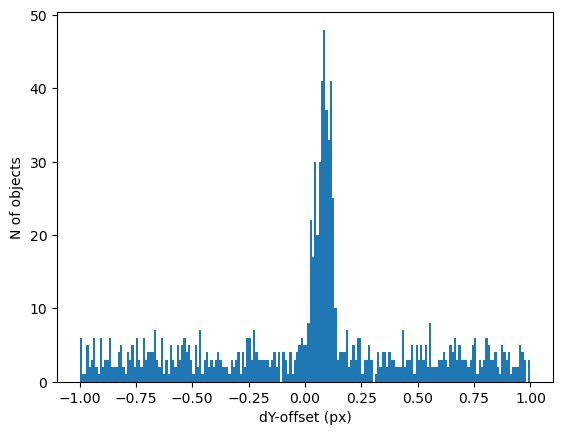

Estimated residual offset dX: 0.020000000000000018 px
Estimated residual offset dY: 0.08000000000000007 px


Evaluating offset...


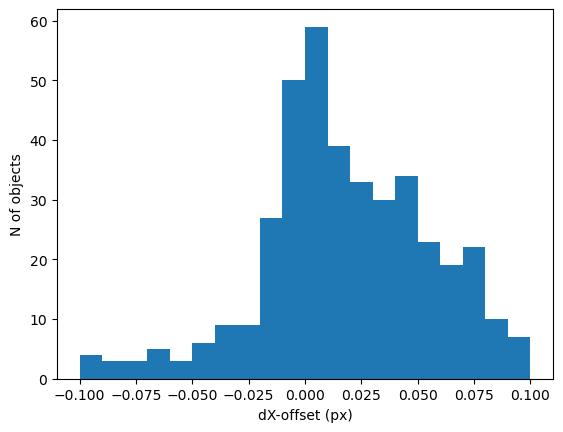

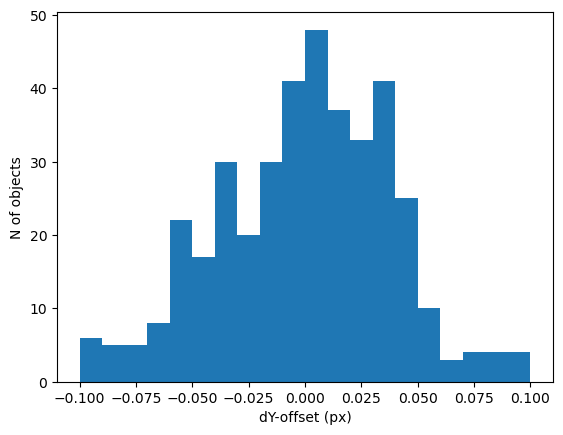

Estimated residual offset dX: 0.0 px
Estimated residual offset dY: 0.0 px


Estimated offset dX: -0.6799999999999993 px
Estimated offset dY: -0.019999999999999574 px


Deviation plot (all):


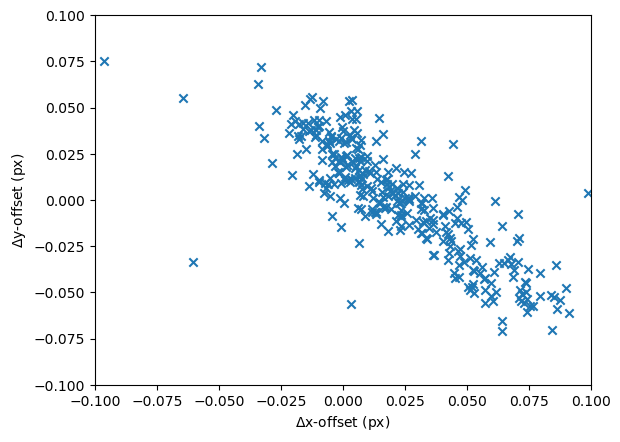

Deviation against pixel phase (all):


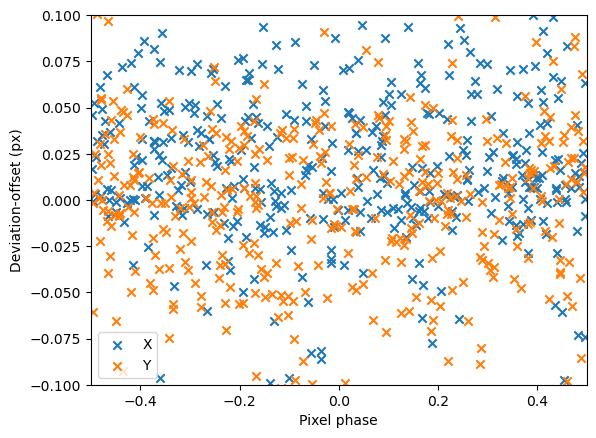

Deviation vector plot (reliable objects only; x2500):


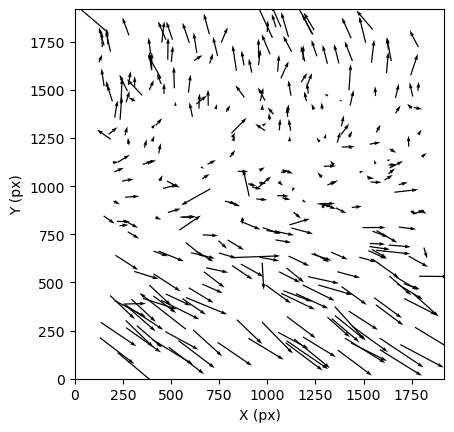

Number of reliable objects: 322


STDDEV dX: 0.030160295007700247 px
STDDEV dY: 0.030382697885774853 px


In [21]:
func('img_ver1_2_B.fits', 'galcen_star_plate.csv')

# Results
Only 334 bright objects are analyzed in this study, and after filtering, 322 data are considered to be reliable. The standard deviation of the position difference is about 0.03 px, corresponding to 14 mas. The vector plot shows a systematic trend, suggesting that the current position determination accuracy is limited by the systematic difference of the ePSF caused by the ACE and the rolling shutter effect of the detector. It is also suggesting that the contamination of close stars is not severe, at least for bright stars, although some stars actually significant deviation from the systematic trend in the vector plot.

## How bright are they?

In [57]:
import pandas as pd

db = pd.read_csv('galcen_star_plate.csv')
db.sort_values('Hwmag')['Hwmag'].values[334]

13.619220932313482

The 334-th brightest object has an Hw magnitude of 13.6 mag. This falls within a medium brightness level in the target brightness range of JASMINE. For such objects, at least in the first step, the systematic ePSF difference across the field has a more severe effect than the contamination effects, and its correction is crucial for the analysis. The contamination effects or the analysis for the fainter objects should be investigated after establishing the correction method. Of course, we have to discuss whether we need to include more faint objects in the simulation or not. We may also have to improve the simulation algorithm to shorten the calculation time, as the image analyzed here took about 4 days to produce.